### ML Model to Predict AQI

#### Load Data

In [42]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [43]:
# Load json file
json_filename = 'jkt_pol_hist.json'
with open(json_filename, 'r') as file:
    json_file = json.load(file)

# Retrieve coordinates
coordinates = json_file['coord']
print(coordinates)

{'lon': 106.8061, 'lat': -6.2923}


Functions to convert μg/m3 to ppb & ppm, calculate US EPA AQI

In [44]:
# Molecular weights dict
MW = {
    "o3": 48.00,
    "co": 28.01,
    "no2": 46.01,
    "so2": 64.07
}

# US EPA AQI Breakpoints
AQI_BREAKPOINTS = {
    "o3_ppb_8hr": [
        (0, 54, 0, 50),
        (55, 70, 51, 100),
        (71, 85, 101, 150),
        (86, 105, 151, 200),
        (106, 200, 201, 300)
    ],
    "o3_ppb_1hr": [
        (125, 164, 101, 150),
        (165, 204, 151, 200),
        (205, 404, 201, 300),
        (405, 504, 301, 400),
        (505, 604, 401, 500)
    ],
    "pm2_5_24hr": [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 350.4, 301, 400),
        (350.5, 500.4, 401, 500)
    ],
    "pm10_24hr": [
        (0, 54, 0, 50),
        (55, 154, 51, 100),
        (155, 254, 101, 150),
        (255, 354, 151, 200),
        (355, 424, 201, 300),
        (425, 504, 301, 400),
        (505, 604, 401, 500)
    ],
    "co_ppm_8hr": [
        (0.0, 4.4, 0, 50),
        (4.5, 9.4, 51, 100),
        (9.5, 12.4, 101, 150),
        (12.5, 15.4, 151, 200),
        (15.5, 30.4, 201, 300),
        (30.5, 40.4, 301, 400),
        (40.5, 50.4, 401, 500)
    ],
    "so2_ppb_1hr": [
        (0, 35, 0, 50),
        (36, 75, 51, 100),
        (76, 185, 101, 150),
        (186, 304, 151, 200)
    ],
    "so2_ppb_24hr": [
        (305, 604, 201, 300),
        (605, 804, 301, 400),
        (805, 1004, 401, 500)
    ],
    "no2_ppb_1hr": [
        (0, 53, 0, 50),
        (54, 100, 51, 100),
        (101, 360, 101, 150),
        (361, 649, 151, 200),
        (650, 1249, 201, 300),
        (1250, 1649, 301, 400),
        (1650, 2049, 401, 500)
    ]
}

# Functions to convert μg/m3 -> ppb and ppm
def ugm3_to_ppm(ugm3, mw):
    """
    Convert μg/m3 to ppm at 25c and 1 atm
    ugm3 : scalar or array-like
    mw   : molecular weight in g/mol
    """
    return (ugm3 * 24.45) / (mw * 1000) # divide by 1000 to go g → mg → L basis\

def ugm3_to_ppb(ugm3, mw):
    """
    Convert µg/m³ to ppb at 25°C & 1 atm.
    ugm3 : scalar or array-like
    mw   : molecular weight in g/mol
    """
    return (ugm3 * 24.45) / mw # no /1000 because ppb = ppm * 1000

def calculate_subindex_aqi(pollutant, concentration):
    """
    Calculate the aqi from individual pollutant
    pollutant: Name of pollutant (String)
    concentration: Concentration of pollutant
    """
    breakpoints = AQI_BREAKPOINTS[pollutant]
    for Clow, Chigh, Ilow, Ihigh in breakpoints:
        if Clow <= concentration <= Chigh:
            return ((Ihigh - Ilow) / (Chigh - Clow)) * (concentration - Clow) + Ilow
    # Handle extrapolation for values above maximum breakpoint
    last_breakpoint = breakpoints[-1]
    Clow, Chigh, Ilow, Ihigh = last_breakpoint
    
    if concentration > Chigh:
        # Linear extrapolation using the last segment's slope
        slope = (Ihigh - Ilow) / (Chigh - Clow)
        extrapolated_aqi = Ihigh + slope * (concentration - Chigh)
        
        # Cap at reasonable maximum (1000 or return raw extrapolation)
        return min(extrapolated_aqi, 1000) 
    return None

# Calculate AQI
def calculate_us_aqi(o3_ppb_8hr, o3_ppb_1hr, pm2_5_24hr, pm10_24hr, co_ppm_8hr, so2_ppb_1hr, so2_ppb_24hr, no2_ppb_1hr):
    """
    
    """
    aqi_values = [
        calculate_subindex_aqi("o3_ppb_8hr", o3_ppb_8hr),
        calculate_subindex_aqi("o3_ppb_1hr", o3_ppb_1hr),
        calculate_subindex_aqi("pm2_5_24hr", pm2_5_24hr),
        calculate_subindex_aqi("pm10_24hr", pm10_24hr),
        calculate_subindex_aqi("co_ppm_8hr", co_ppm_8hr),
        calculate_subindex_aqi("so2_ppb_1hr", so2_ppb_1hr),
        calculate_subindex_aqi("so2_ppb_24hr", so2_ppb_24hr),
        calculate_subindex_aqi("no2_ppb_1hr", no2_ppb_1hr)
    ]

    valid_aqi_values = [aqi for aqi in aqi_values if aqi is not None]
    if len(valid_aqi_values) > 0:
        return max(valid_aqi_values)
    return None

In [45]:
from datetime import datetime
# deal with the nested json list
data_rows = []
for item in json_file['list']:
    datetime_object = datetime.utcfromtimestamp(item['dt'])
    formatted_dt = datetime_object.strftime("%Y-%m-%d %H:%M:%S")
    row = {
        'datetime': formatted_dt,
        # 'datetime': item['dt'],
        'aqi': item['main']['aqi'],
        'co': item['components']['co'],
        'no2': item['components']['no2'],
        'o3': item['components']['o3'],
        'so2': item['components']['so2'],
        'pm2_5': item['components']['pm2_5'],
        'pm10': item['components']['pm10'],
    }
    data_rows.append(row) # append each row to the list

# Create DataFrame from the list of rows
raw_df = pd.DataFrame(data_rows)

raw_df.set_index('datetime', inplace=True)
raw_df.tail()

,aqi,co,no2,o3,so2,pm2_5,pm10
datetime,,,,,,,
2024-08-06 23:00:00,5,17303.47,164.51,0.00,101.09,691.60,862.55
2024-08-07 00:00:00,5,17303.47,135.72,0.01,84.88,671.97,856.01
2024-08-07 01:00:00,5,19866.94,123.38,0.13,89.65,646.61,836.42
2024-08-07 02:00:00,5,21575.93,126.12,0.42,101.09,611.83,799.89
2024-08-07 03:00:00,5,20294.19,172.73,5.10,103.00,573.96,752.79


Create new data frames

In [46]:
# Convert datetime index first
raw_df.index = pd.to_datetime(raw_df.index)

# Create rolling averages
co_8hr = ugm3_to_ppm(raw_df['co'], MW['co']).rolling(window=8).mean() # convert first, then calculates the rolling window
o3_8hr = ugm3_to_ppb(raw_df['o3'], MW['o3']).rolling(window=8).mean()
pm25_24hr = raw_df['pm2_5'].rolling(window=24).mean()
pm10_24hr = raw_df['pm10'].rolling(window=24).mean()
so2_24hr = ugm3_to_ppb(raw_df['so2'], MW['so2']).rolling(window=24).mean()

# Create the processed dataframe
us_aqi_df = pd.DataFrame({
    'co_ppm_8hr': co_8hr,
    'no2_ppb_1hr': ugm3_to_ppb(raw_df['no2'], MW['no2']),
    'o3_ppb_8hr': o3_8hr,
    'o3_ppb_1hr': ugm3_to_ppb(raw_df['o3'], MW['o3']),
    'pm2_5_24hr': pm25_24hr,
    'pm10_24hr': pm10_24hr,
    'so2_ppb_1hr': ugm3_to_ppb(raw_df['so2'], MW['so2']),
    'so2_ppb_24hr': so2_24hr
}, index=raw_df.index)

print(us_aqi_df[:100])

                     co_ppm_8hr  no2_ppb_1hr  o3_ppb_8hr  o3_ppb_1hr  \
datetime                                                               
2020-11-25 01:00:00         NaN    11.292382         NaN    0.213938   
2020-11-25 02:00:00         NaN    14.571158         NaN    0.392219   
2020-11-25 03:00:00         NaN    18.211291         NaN    0.657094   
2020-11-25 04:00:00         NaN    18.758639         NaN    0.911781   
2020-11-25 05:00:00         NaN    18.758639         NaN    0.616344   
...                         ...          ...         ...         ...   
2020-11-29 00:00:00    0.716024     9.655651    2.457734    0.336188   
2020-11-29 01:00:00    0.829656    10.474017    2.363500    0.122250   
2020-11-29 02:00:00    0.978250    11.111704    2.185855    0.264875   
2020-11-29 03:00:00    1.086782    11.563399    1.870680    0.713125   
2020-11-29 04:00:00    1.115191     9.836329    1.768168    3.280375   

                     pm2_5_24hr  pm10_24hr  so2_ppb_1hr  so2_pp

In [47]:
# drop NaN values
us_aqi_df.isnull().sum()

co_ppm_8hr       7
no2_ppb_1hr      0
o3_ppb_8hr       7
o3_ppb_1hr       0
pm2_5_24hr      23
pm10_24hr       23
so2_ppb_1hr      0
so2_ppb_24hr    23
dtype: int64

In [48]:
preprocessed_df = pd.DataFrame(us_aqi_df.dropna())
preprocessed_df.isnull().sum()

co_ppm_8hr      0
no2_ppb_1hr     0
o3_ppb_8hr      0
o3_ppb_1hr      0
pm2_5_24hr      0
pm10_24hr       0
so2_ppb_1hr     0
so2_ppb_24hr    0
dtype: int64

In [49]:
# calculate each aqi
preprocessed_df['us_aqi'] = preprocessed_df.apply(
    lambda row: calculate_us_aqi(
        row['o3_ppb_8hr'], row['o3_ppb_1hr'],
        row['pm2_5_24hr'], row['pm10_24hr'],
        row['co_ppm_8hr'], row['so2_ppb_1hr'],
        row['so2_ppb_24hr'], row['no2_ppb_1hr']
    ), axis=1  # Apply along rows (axis=1)
)
preprocessed_df[:100]

,co_ppm_8hr,no2_ppb_1hr,o3_ppb_8hr,o3_ppb_1hr,pm2_5_24hr,pm10_24hr,so2_ppb_1hr,so2_ppb_24hr,us_aqi
datetime,,,,,,,,,
2020-11-26 00:00:00,9.999566,10.017007,0.000637,0.005094,221.111250,334.101667,12.555096,24.490069,270.975113
2020-11-26 01:00:00,8.163981,13.662454,0.004457,0.030562,223.729583,337.755417,16.558225,24.664499,273.569857
2020-11-26 02:00:00,6.742132,16.574560,0.011461,0.056031,226.323750,341.151667,21.835945,24.914615,276.140653
2020-11-26 03:00:00,5.809772,18.397283,0.022285,0.086594,229.197917,345.003333,27.659373,25.316422,278.988926
2020-11-26 04:00:00,5.075539,19.486666,0.033109,0.086594,230.769583,347.090000,21.652770,25.703125,280.546434
...,...,...,...,...,...,...,...,...,...
2020-11-29 23:00:00,0.888657,9.017963,1.164559,0.575594,21.203750,35.607917,3.819955,4.816603,70.145225
2020-11-30 00:00:00,0.871175,9.017963,1.192574,0.234313,21.353333,35.712500,5.548666,4.869552,70.459800
2020-11-30 01:00:00,1.015401,10.288024,1.247969,0.483906,21.657917,35.937500,8.372608,4.941581,71.100340


### EDA & Data cleaning

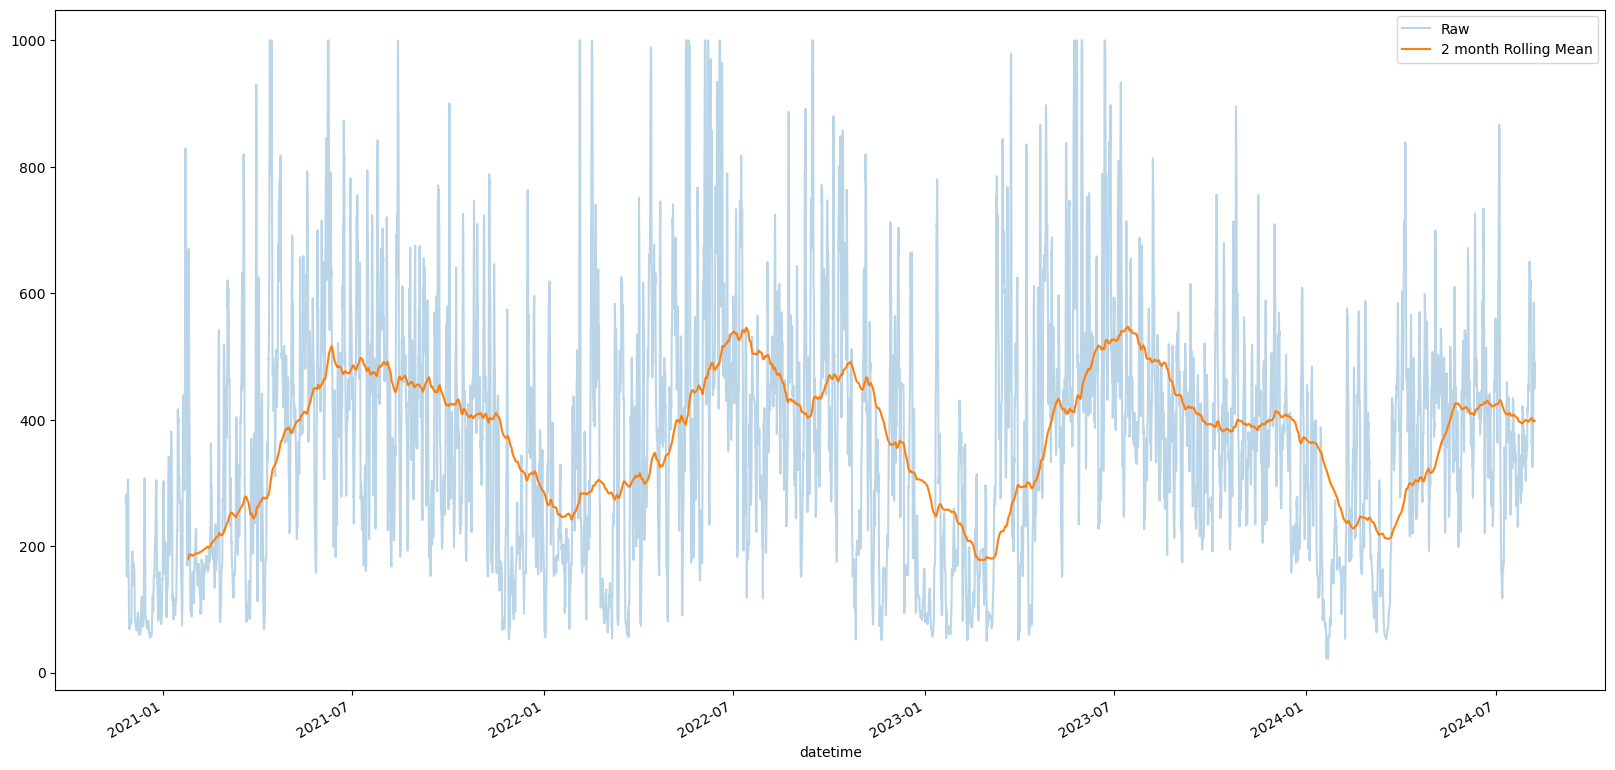

In [50]:
preprocessed_df['us_aqi'].plot(alpha=0.3, label='Raw')
preprocessed_df['us_aqi'].rolling(720*2).mean().plot(label='2 month Rolling Mean')
plt.legend()

In [51]:
preprocessed_df.to_csv('output.csv', index=False)

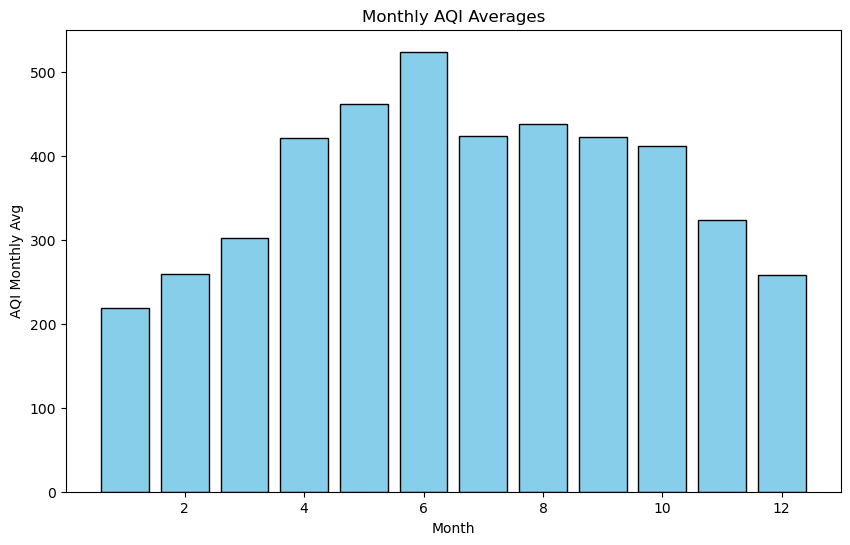

In [52]:
# Visualize monthly AQI
# Group data by monthly average
monthly_avg = preprocessed_df.groupby(preprocessed_df.index.month)['us_aqi'].mean()
plt.figure(figsize=(10, 6))

plt.bar(monthly_avg.index, monthly_avg, color='skyblue', edgecolor='black')

plt.xlabel('Month')
plt.ylabel('AQI Monthly Avg')
plt.title('Monthly AQI Averages')
plt.show()

Insight: AQI spikes at the middle of the year.

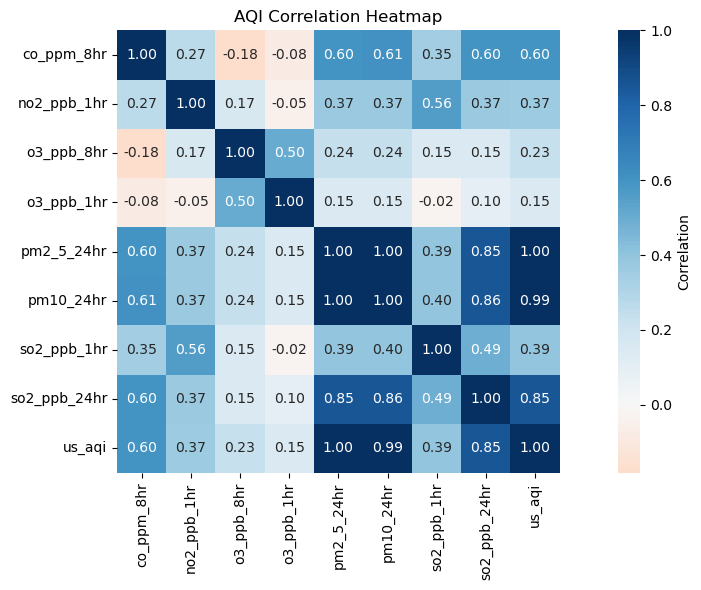

In [53]:
# Create Correlation Matrix
corr_matrix = preprocessed_df.corr()

# Create Correlation Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix,
            annot=True, # Show correlation values
            cmap='RdBu', # Color scheme
            center=0, # Center colormap at 0
            square=True, # Make cells square
            fmt='.2f', # Format numbers to 2 decimal
            cbar_kws = ({'label': 'Correlation'})
            )
plt.title('AQI Correlation Heatmap')
plt.tight_layout()
plt.show()

Does not show much of a strong correlation (us_aqi with other features.) The relationship might be non-linear.

But, so2_ppb_24hr might be redundant to keep because of a high correlation score with pm2.5 and pm10 (multicollinearity)

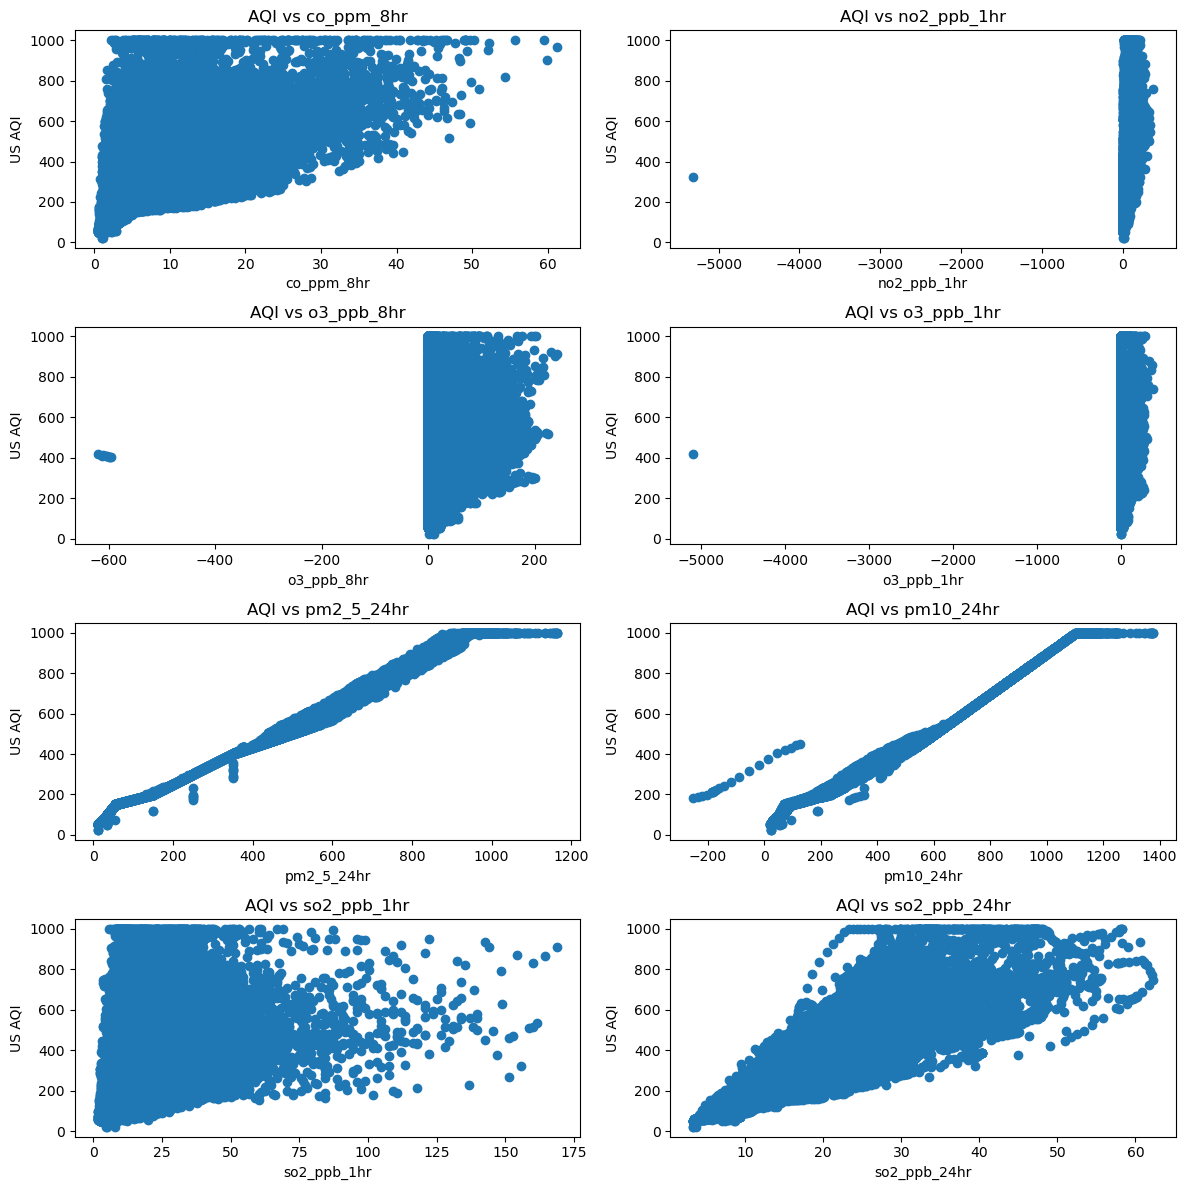

In [54]:
# Scatter plots of each feature with AQI to find linear relationships
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(12,12))

pollutants = [col for col in preprocessed_df.columns if col != 'us_aqi']
for i, pollutant in enumerate(pollutants):
    row = i // 2
    col = i % 2
    axes[row, col].scatter(preprocessed_df[pollutants[i]], preprocessed_df['us_aqi'])
    axes[row, col].set_xlabel(pollutants[i])
    axes[row, col].set_ylabel('US AQI')
    axes[row, col].set_title(f'AQI vs {pollutants[i]}')
plt.tight_layout()

In [55]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31948 entries, 2020-11-26 00:00:00 to 2024-08-07 03:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   co_ppm_8hr    31948 non-null  float64
 1   no2_ppb_1hr   31948 non-null  float64
 2   o3_ppb_8hr    31948 non-null  float64
 3   o3_ppb_1hr    31948 non-null  float64
 4   pm2_5_24hr    31948 non-null  float64
 5   pm10_24hr     31948 non-null  float64
 6   so2_ppb_1hr   31948 non-null  float64
 7   so2_ppb_24hr  31948 non-null  float64
 8   us_aqi        31948 non-null  float64
dtypes: float64(9)
memory usage: 2.4 MB


Insight: 
1. A linear relationship between AQI and pm substance. Slightly weird patterns likely caused due to other prominent data causing the AQI to spike.
2. Outliers on O3 and NO2 causing the scatter plot looking shrunk.

In [56]:
# Remove outliers from o3 and no2
cutoff_no2 = preprocessed_df['no2_ppb_1hr'].quantile(0.005)
cutoff_o3 = preprocessed_df['o3_ppb_1hr'].quantile(0.005)
cutoff_o3_8hr = preprocessed_df['o3_ppb_8hr'].quantile(0.005)

clean_df = preprocessed_df[preprocessed_df['no2_ppb_1hr'] > cutoff_no2]
clean_df = clean_df[preprocessed_df['o3_ppb_1hr'] > cutoff_o3]
clean_df = clean_df[preprocessed_df['o3_ppb_8hr'] > cutoff_o3_8hr]
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18565 entries, 2020-11-26 00:00:00 to 2024-08-07 03:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   co_ppm_8hr    18565 non-null  float64
 1   no2_ppb_1hr   18565 non-null  float64
 2   o3_ppb_8hr    18565 non-null  float64
 3   o3_ppb_1hr    18565 non-null  float64
 4   pm2_5_24hr    18565 non-null  float64
 5   pm10_24hr     18565 non-null  float64
 6   so2_ppb_1hr   18565 non-null  float64
 7   so2_ppb_24hr  18565 non-null  float64
 8   us_aqi        18565 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


C:\Users\Mahesa\AppData\Local\Temp\ipykernel_27944\2859218065.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean_df = clean_df[preprocessed_df['o3_ppb_1hr'] > cutoff_o3]
C:\Users\Mahesa\AppData\Local\Temp\ipykernel_27944\2859218065.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean_df = clean_df[preprocessed_df['o3_ppb_8hr'] > cutoff_o3_8hr]


In [57]:
# Detect missing values
missing_values = preprocessed_df.index.difference(clean_df.index)
print(len(missing_values))

13383


In [58]:
# Re-create the data with complete time index
start_time = clean_df.index.min()
end_time = clean_df.index.max()
complete_index = pd.date_range(start=start_time, end=end_time, freq='H')
print(len(complete_index))
print(len(clean_df))

32404
18565


In [59]:
complete_index_df = clean_df.reindex(complete_index)
print(len(complete_index_df))
print(complete_index_df.isna().sum())

32404
co_ppm_8hr      13839
no2_ppb_1hr     13839
o3_ppb_8hr      13839
o3_ppb_1hr      13839
pm2_5_24hr      13839
pm10_24hr       13839
so2_ppb_1hr     13839
so2_ppb_24hr    13839
us_aqi          13839
dtype: int64


In [60]:
# fill null data with nearest neighbour's data
complete_df = complete_index_df.interpolate(method='nearest')
print(complete_df.isna().sum())

co_ppm_8hr      0
no2_ppb_1hr     0
o3_ppb_8hr      0
o3_ppb_1hr      0
pm2_5_24hr      0
pm10_24hr       0
so2_ppb_1hr     0
so2_ppb_24hr    0
us_aqi          0
dtype: int64


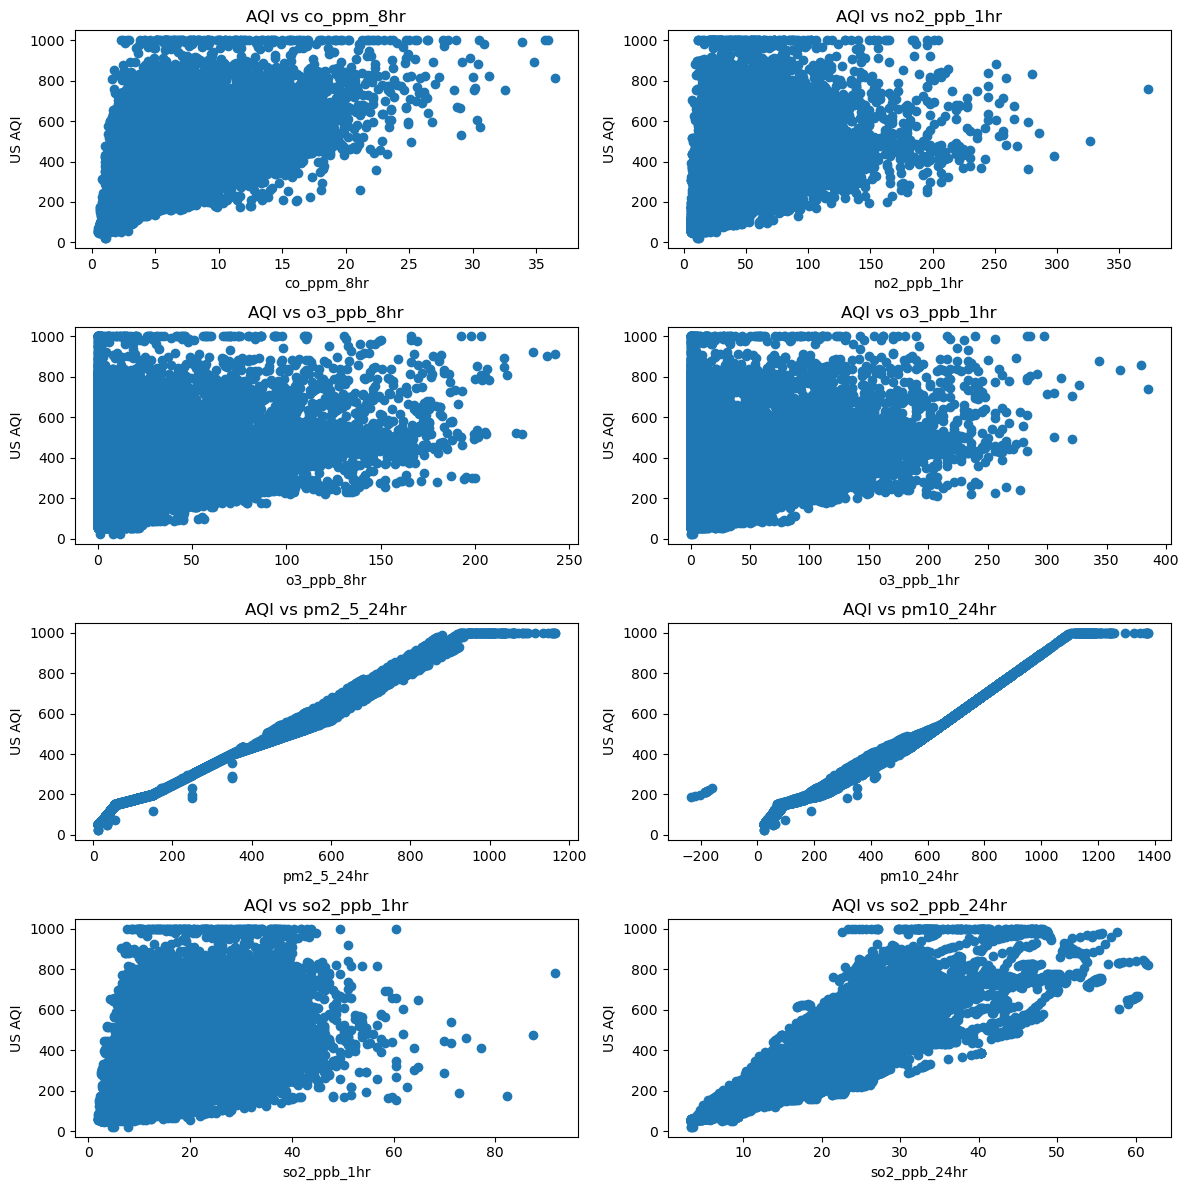

In [61]:
# Remake the scatter plot
# Scatter plots of each feature with AQI to find linear relationships
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(12,12))

pollutants = [col for col in clean_df.columns if col != 'us_aqi']
for i, pollutant in enumerate(pollutants):
    row = i // 2
    col = i % 2
    axes[row, col].scatter(clean_df[pollutants[i]], clean_df['us_aqi'])
    axes[row, col].set_xlabel(pollutants[i])
    axes[row, col].set_ylabel('US AQI')
    axes[row, col].set_title(f'AQI vs {pollutants[i]}')
plt.tight_layout()

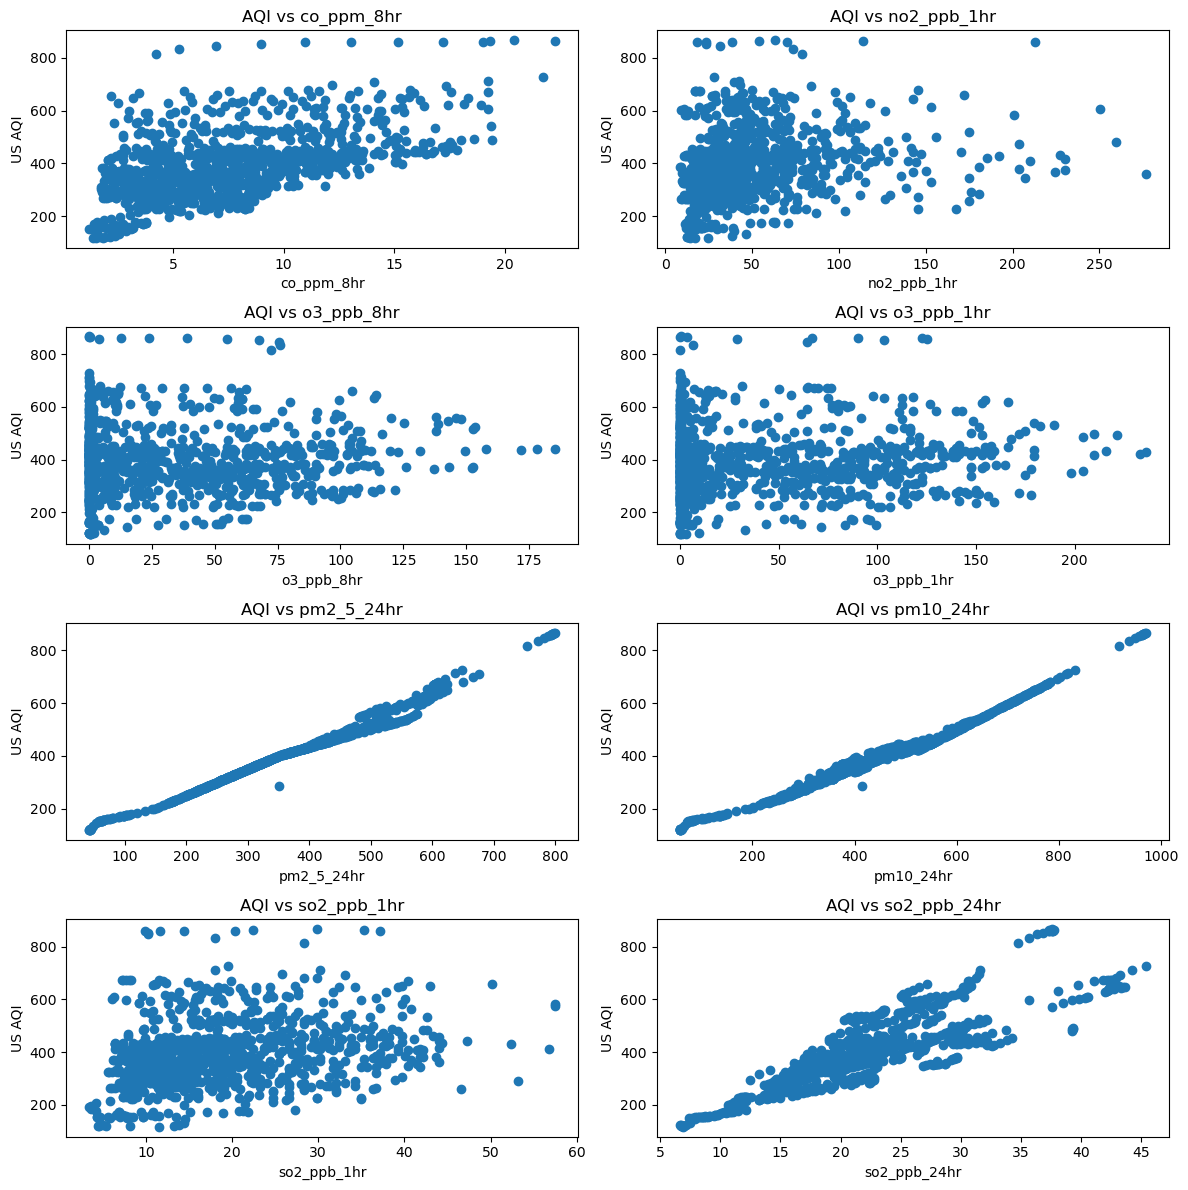

In [62]:
# Scatter plot of recent 1000 data entry
clean_df_recent_1000 = clean_df.tail(1000)
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(12,12))

pollutants = [col for col in clean_df_recent_1000.columns if col != 'us_aqi']
for i, pollutant in enumerate(pollutants):
    row = i // 2
    col = i % 2
    axes[row, col].scatter(clean_df_recent_1000[pollutants[i]], clean_df_recent_1000['us_aqi'])
    axes[row, col].set_xlabel(pollutants[i])
    axes[row, col].set_ylabel('US AQI')
    axes[row, col].set_title(f'AQI vs {pollutants[i]}')
plt.tight_layout()
plt.show()

In [63]:
# Check which pollutants reach their breakpoints
# Check AQI distribution
print(f"\n=== AQI DISTRIBUTION (AFTER CLEANING) ===")
print(f"AQI range: {clean_df['us_aqi'].min():.0f} - {clean_df['us_aqi'].max():.0f}")
print(f"AQI mean: {clean_df['us_aqi'].mean():.1f}")
print("\nAQI categories:")
aqi_ranges = [(0, 50, "Good"), (51, 100, "Moderate"), (101, 150, "Unhealthy for Sensitive"), 
              (151, 200, "Unhealthy"), (201, 300, "Very Unhealthy"), (301, 500, "Hazardous")]

for low, high, category in aqi_ranges:
    count = ((clean_df['us_aqi'] >= low) & (clean_df['us_aqi'] <= high)).sum()
    pct = (count / len(clean_df)) * 100
    print(f"{category} ({low}-{high}): {pct:.2f}%") 
    print(f"Count ({low}-{high}): {count}")
    print("------------------------------")


=== AQI DISTRIBUTION (AFTER CLEANING) ===
AQI range: 22 - 1000
AQI mean: 349.6

AQI categories:
Good (0-50): 0.06%
Count (0-50): 11
------------------------------
Moderate (51-100): 10.64%
Count (51-100): 1975
------------------------------
Unhealthy for Sensitive (101-150): 5.69%
Count (101-150): 1056
------------------------------
Unhealthy (151-200): 12.21%
Count (151-200): 2266
------------------------------
Very Unhealthy (201-300): 15.71%
Count (201-300): 2917
------------------------------
Hazardous (301-500): 36.12%
Count (301-500): 6706
------------------------------


Won't help much with the model (i think), but shows that Jakarta has a high hazardous AQI frequency

### Feature Selection

In [64]:
clean2_df = clean_df.drop('so2_ppb_24hr', axis=1)
clean2_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18565 entries, 2020-11-26 00:00:00 to 2024-08-07 03:00:00
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   co_ppm_8hr   18565 non-null  float64
 1   no2_ppb_1hr  18565 non-null  float64
 2   o3_ppb_8hr   18565 non-null  float64
 3   o3_ppb_1hr   18565 non-null  float64
 4   pm2_5_24hr   18565 non-null  float64
 5   pm10_24hr    18565 non-null  float64
 6   so2_ppb_1hr  18565 non-null  float64
 7   us_aqi       18565 non-null  float64
dtypes: float64(8)
memory usage: 1.8 MB


Time Series Decomposition

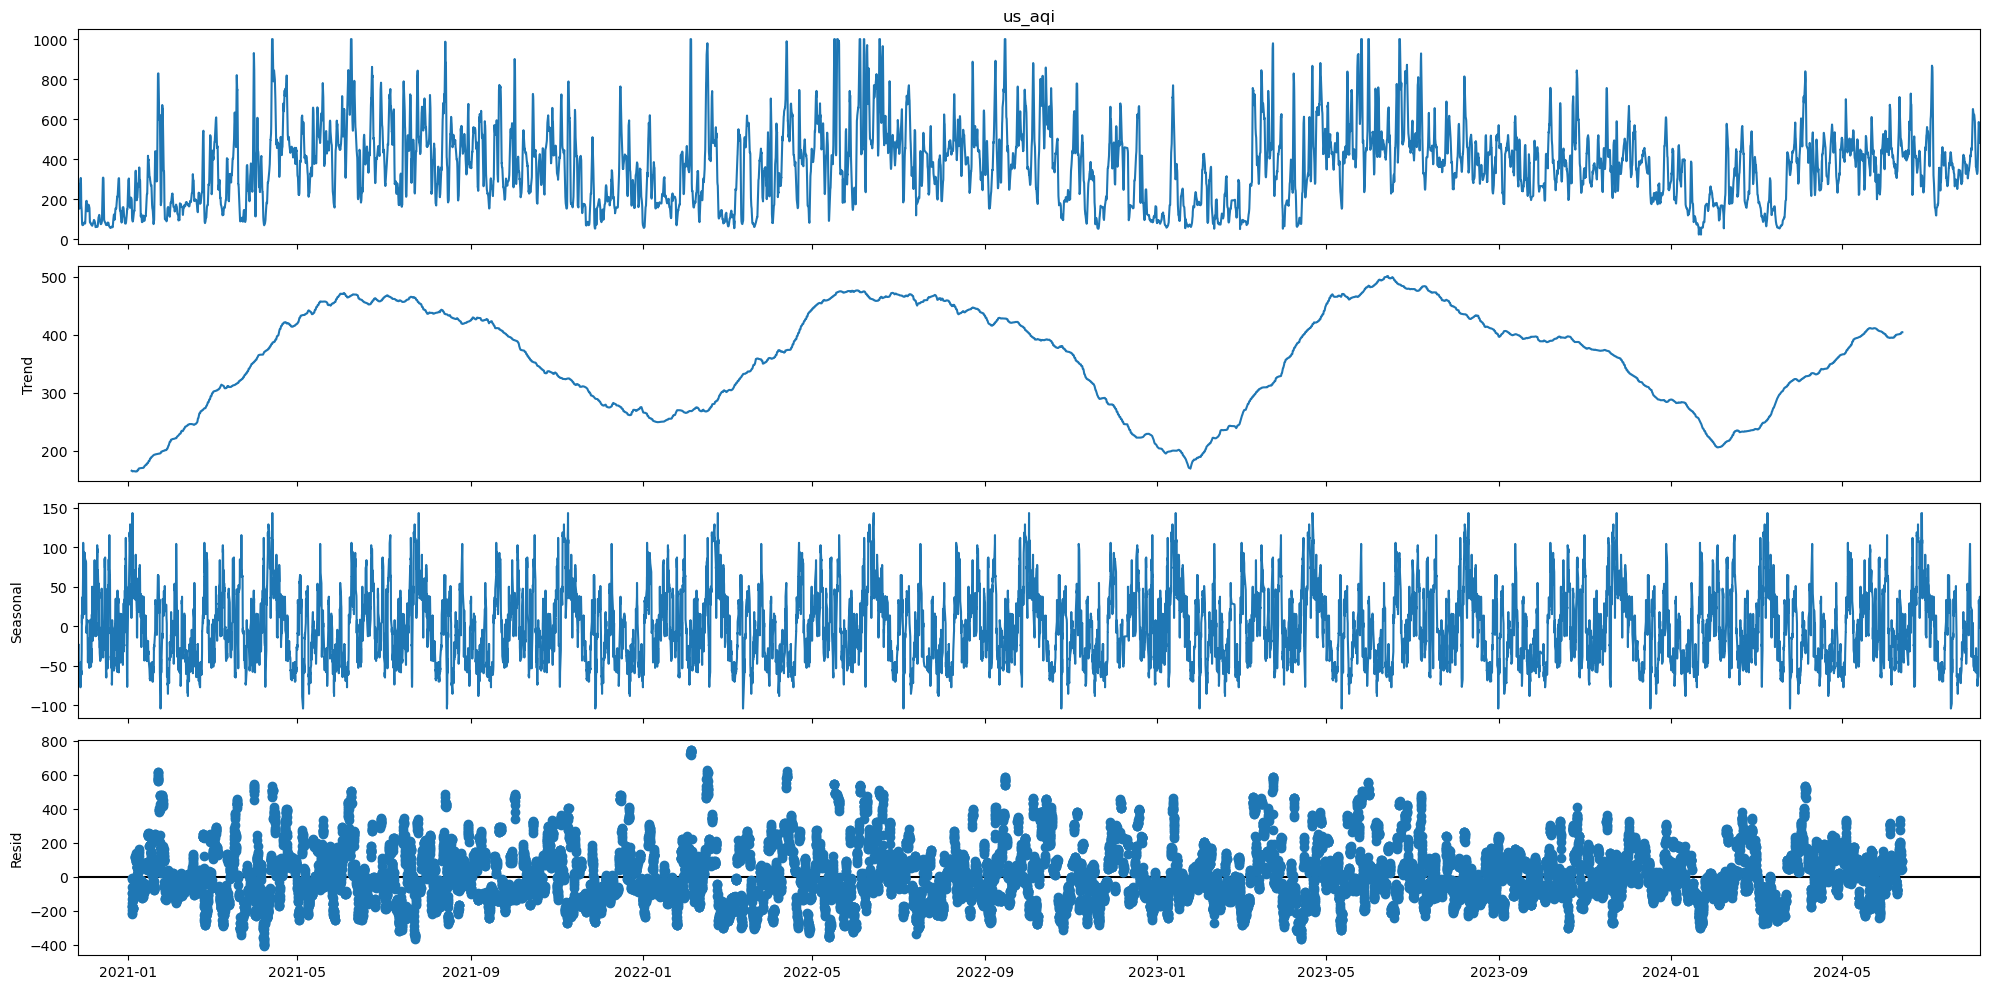

In [65]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(clean2_df['us_aqi'], model='additive', period=24*60) # 3 month periods time frame
fig = decomposition.plot()

plt.show()

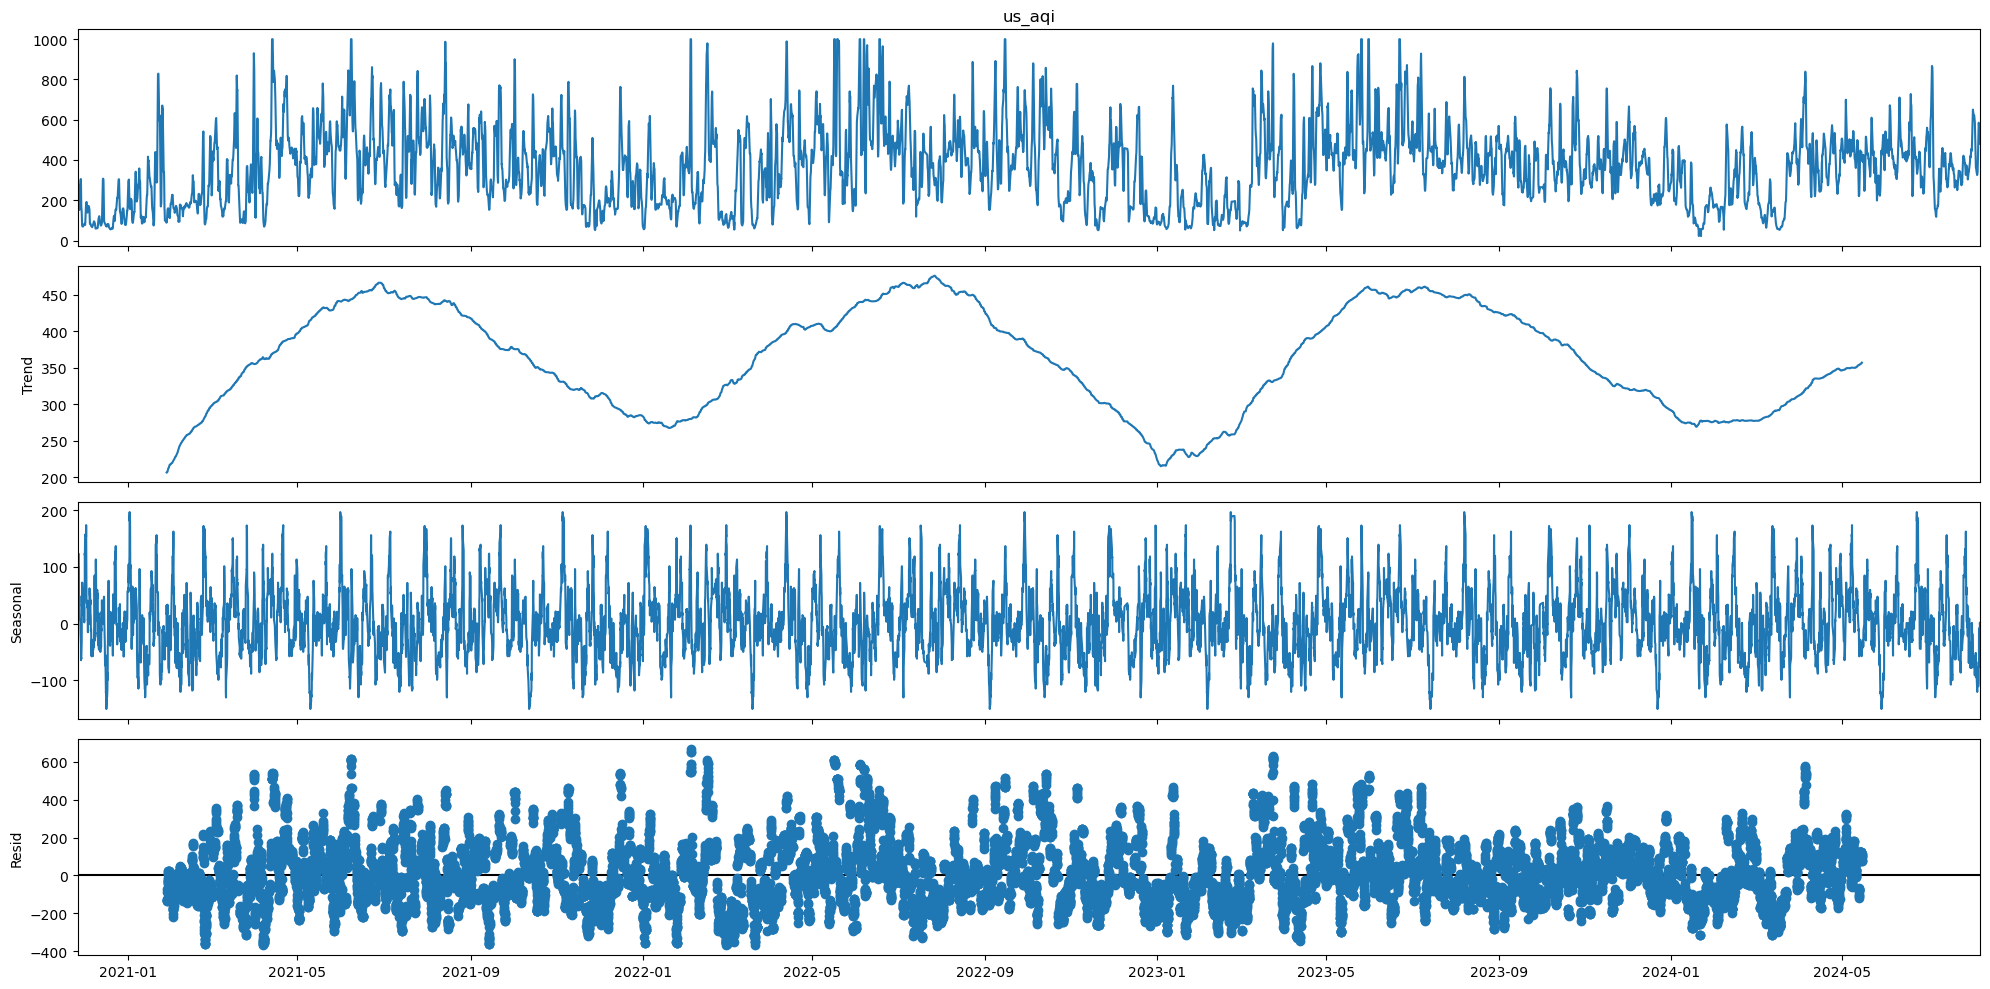

In [66]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(clean2_df['us_aqi'], model='additive', period=24*90) # 3 month periods time frame
fig = decomposition.plot()

plt.show()

### Building and testing models

Try out XGBoost and SARIMA